In [ ]:
!conda install -c bioconda -c conda-forge quast -y

 ### Task 1.1: De Bruijn Graph (DBG) Assembly

In [1]:
from collections import defaultdict, Counter

def parse_fastq(file_path):
    """
    just parses a FASTQ file and returns a list of read sequences.
    """
    reads = []
    with open(file_path, 'r') as f:
        while True:
            header = f.readline()  # reading the top line that has the sequence identifier
            seq = f.readline().strip()  # reading the sequence
            plus = f.readline()  # '+' line
            qual = f.readline()  # reading the wuality scores
            if not qual:  # end of file
                break
            reads.append(seq)
    return reads

def build_kmer_counts(reads, k):
    """
    counts all k-mers of length k in the list of reads then returns a counter with k-mer counts.
    """
    counts = Counter()
    for read in reads:
        for i in range(len(read) - k + 1):
            kmer = read[i:i+k]
            counts[kmer] += 1
    return counts

def build_filtered_dbg(counts, k, min_count=2):
    """
    builds a DBG from k-mer counts then filters out k-mers with the if condition counts < min_count. Finally, it returns adjacency list graph and degree dictionaries.
    """
    graph = defaultdict(list)
    in_degree = defaultdict(int)
    out_degree = defaultdict(int)

    for kmer, count in counts.items():
        if count < min_count:
            continue  #  if for example min_count = 2, it will filter out k-mers that only appear once.
        prefix = kmer[:-1]  # k-1 prefix
        suffix = kmer[1:]   # k-1 suffix
        graph[prefix].append(suffix)  # adding directed edge
        out_degree[prefix] += 1
        in_degree[suffix] += 1

    return graph, in_degree, out_degree

def assemble_unitigs(graph, in_degree, out_degree):
    """
    assembles the unitigs (basically the non-branching paths) from the DBG, then returns a list of assembled contig sequences.
    """
    contigs = []
    visited = set()

    for node in graph:
        # starting a new unitig if the node is a tip or already visited
        if (in_degree[node] != 1 or out_degree[node] != 1) and (node not in visited):
            for neighbor in graph[node]:
                path = [node, neighbor]
                visited.add((node, neighbor))
                current = neighbor
                # continuiong until a branching node is found
                while in_degree[current] == 1 and out_degree[current] == 1:
                    next_node = graph[current][0]
                    visited.add((current, next_node))
                    path.append(next_node)
                    current = next_node
                # reconstructing the contig sequence from path
                contig = path[0] + ''.join(n[-1] for n in path[1:])
                contigs.append(contig)

    return contigs

def write_fasta(contigs, output_file):
    """
    writes the assembled contigs to a FASTA file. Each contig is given a header >contig_i which is important so it can be read properly later.
    """
    with open(output_file, 'w') as f:
        for i, contig in enumerate(contigs):
            f.write(f">contig_{i}\n{contig}\n")


In [13]:
# files to be read and outputted to. Make sure the directories "synthetic" and "outputs" have the reads and references.
input_fastq = "synthetic/reads_b.fastq"
kmer_size = 40
output_fasta = "outputs/reads_b_contigs_k40.fasta"

reads = parse_fastq(input_fastq)
kmer_counts = build_kmer_counts(reads, kmer_size)
graph, in_deg, out_deg = build_filtered_dbg(kmer_counts, kmer_size, min_count=2)
contigs = assemble_unitigs(graph, in_deg, out_deg)
write_fasta(contigs, output_fasta)
print(f"Generated {len(contigs)} contigs.")

Generated 1 contigs.


In [3]:
!quast outputs/reads_b_contigs_k40.fasta -r synthetic/reference_b.fasta -o outputs/quast_b_k40 --min-contig 0

/home/saitaa0b/miniconda3/envs/bioasst2/bin/quast outputs/reads_b_contigs_k40.fasta -r synthetic/reference_b.fasta -o outputs/quast_b_k40 --min-contig 0

Version: 5.3.0

System information:
  OS: Linux-5.14.0-427.20.1.el9_4.0.1.x86_64-x86_64-with-glibc2.34 (linux_64)
  Python version: 3.9.19
  CPUs number: 32

Started: 2025-05-09 06:34:55

Logging to /home/saitaa0b/bio/outputs/quast_b_k40/quast.log
NOTICE: Output directory already exists and looks like a QUAST output dir. Existing results can be reused (e.g. previously generated alignments)!
NOTICE: Maximum number of threads is set to 8 (use --threads option to set it manually)

CWD: /home/saitaa0b/bio
Main parameters: 
  MODE: default, threads: 8, min contig length: 0, min alignment length: 65, min alignment IDY: 95.0, \
  ambiguity: one, min local misassembly length: 200, min extensive misassembly length: 1000

Reference:
  /home/saitaa0b/bio/synthetic/reference_b.fasta ==> reference_b

Contigs:
  Pre-processing...
  outputs/reads_b_

In [4]:
def parse_quast_report(report_path):
    """
    collecting the metrics we want from QUAST.
    """
    desired_metrics = {
        "Total length": "Sequence length",
        "# contigs (>= 0 bp)": "# contigs (>= 0 bp)",
        "# contigs (>= 1000 bp)": "# contigs (>= 1000 bp)",
        "# contigs (>= 5000 bp)": "# contigs (>= 5000 bp)",
        "# contigs (>= 10000 bp)": "# contigs (>= 10000 bp)",
        "# contigs (>= 25000 bp)": "# contigs (>= 25000 bp)",
        "# contigs (>= 50000 bp)": "# contigs (>= 50000 bp)",
        "GC (%)": "GC content (%)",
        "Genome fraction (%)": "Genome fraction (%)",
        "Duplication ratio": "Duplication ratio",
        "Largest contig": "Largest contig",
        "N50": "N50",
        "N90": "N90",
        "L50": "L50",
        "# misassemblies": "Misassemblies",
        "# mismatches per 100 kbp": "Mismatches per 100 kbp",
        "# indels per 100 kbp": "Indels per 100 kbp"
    }

    metrics_out = {label: None for label in desired_metrics.values()}

    with open(report_path, 'r') as f:
        for line in f:
            for key, label in desired_metrics.items():
                if line.startswith(key):
                    value = line.strip().split()[-1]
                    metrics_out[label] = value

    return metrics_out

report_path = "outputs/quast_b_k40/report.txt"
metrics = parse_quast_report(report_path)

print("Parsed QUAST Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v}")

Parsed QUAST Metrics:
Sequence length: 1000
# contigs (>= 0 bp): 1
# contigs (>= 1000 bp): 1
# contigs (>= 5000 bp): 0
# contigs (>= 10000 bp): 0
# contigs (>= 25000 bp): 0
# contigs (>= 50000 bp): 0
GC content (%): 52.00
Genome fraction (%): 100.000
Duplication ratio: 1.000
Largest contig: 1000
N50: 1000
N90: 1000
L50: 1
Misassemblies: 0
Mismatches per 100 kbp: 0.00
Indels per 100 kbp: 0.00


### QUAST evaluation

| **Metric**                 | **B k=40 (DBG)** |
|----------------------------|------------------|
| Sequence length            |1000                  |
| # contigs (>= 0 bp)        |1                  |
| # contigs (>= 1000 bp) |1                  |           
| # contigs (>= 5000 bp) |0                  |            
| # contigs (>= 10000 bp)|0                  |         
| # contigs (>= 25000 bp)|0                  |          
| # contigs (>= 50000 bp)|0                  |               
| GC content (%)             |52.00                  | 
| Genome fraction (%)        |100.000                  |                
| Duplication ratio          |1.000                  |                  
| Largest contig             |1000                  |                  
| N50                        |1000                  |                  
| N90                        |1000                  |               
| L50                        |1                  |                 
| Misassemblies              |0                  |              
| Mismatches per 100 kbp     |0.00                  |            
| Indels per 100 kbp         |0.00                  |       


### Task 1.2: Overlap-Layout-Consensus (OLC) Assembly

In [ ]:
from collections import defaultdict, Counter
import difflib

def parse_fastq(file_path):
    """
    just parses a FASTQ file and returns a list of read sequences.
    """
    reads = []
    with open(file_path, 'r') as f:
        while True:
            header = f.readline()  # reading the top line that has the sequence identifier
            seq = f.readline().strip()  # reading the sequence
            plus = f.readline()  # '+' line
            qual = f.readline()  # reading the wuality scores
            if not qual:  # end of file
                break
            reads.append(seq)
    return reads

def reverse_complement(seq):
    """
    returning the reverse complement of a DNA sequence.
    """
    complement = str.maketrans("ACGT", "TGCA")
    return seq.translate(complement)[::-1]

def overlap(a, b, min_length=30):
    """
    finding the length of the longest suffix of 'a' (the contig) that matches the prefix of 'b' (the target read). This requires a minimum overlap length to consider it valid.
    """
    start = 0
    while True:
        start = a.find(b[:min_length], start) # looking for match starting at b's prefix
        if start == -1:
            return 0
        if b.startswith(a[start:]): # checking full suffix-prefix match from that point
            return len(a) - start
        start += 1

def remove_contained_reads(reads):
    """
    removing reads that are entirely contained in another read. This is another filtration step to simplify the overlap graph later.
    """
    non_contained = []
    for i, a in enumerate(reads):
        is_contained = False
        for j, b in enumerate(reads):
            if i != j and a in b:
                is_contained = True
                break
        if not is_contained:
            non_contained.append(a)
    return non_contained

def build_overlap_graph(reads, min_length):
    """
    constructing an overlap graph where edges represent overlaps of length >= min_length. Then, it returns adjacency list and in and out degrees of nodes.
    """
    graph = defaultdict(list)
    indegree = defaultdict(int)
    outdegree = defaultdict(int)

    for a in reads:
        for b in reads:
            if a == b:
                continue
            olen = overlap(a, b, min_length)
            if olen > 0:
                graph[a].append((b, olen))
                outdegree[a] += 1
                indegree[b] += 1
    return graph, indegree, outdegree

def consensus_merge(read1, read2, olen):
    """
    merging two reads using the consensus of overlapping region. To tie-break, we use the most common base in mismatches.
    """
    prefix = read1[:-olen]
    overlap1 = read1[-olen:]
    overlap2 = read2[:olen]
    suffix = read2[olen:]

    merged = []
    for base1, base2 in zip(overlap1, overlap2):
        if base1 == base2:
            merged.append(base1) # no conflict, so we append.
        else:
            count = Counter([base1, base2])
            merged.append(count.most_common(1)[0][0]) # choosing the base with the higher count

    return prefix + ''.join(merged) + suffix # final contig

def layout_reads_consensus(graph, indegree, outdegree, reads, min_contig_len=200):
    """
    traversing the overlap graph and constructing contigs. Only starts paths from non-1-in-1-out nodes.
    """
    contigs = []
    used = set() # nodes already used in the layout
    used_reads = set() # reads that are already merged

    for node in list(graph):
        # skipping already used nodes and simple 1-in-1-out nodes
        if node in used or (indegree[node] == 1 and outdegree[node] == 1):
            continue

        path = node # initializing the contig path
        used.add(node)
        used_reads.add(node)
        current = node

        while graph[current]:
            # picking the next node with the maximum overlap length
            next_read, olen = max(graph[current], key=lambda x: x[1])
            if next_read in used:
                break # to avoid cycles
            path = consensus_merge(path, next_read, olen)
            used.add(next_read)
            used_reads.add(next_read)
            current = next_read

        if len(path) >= min_contig_len:
            contigs.append(path)

    return contigs

def polish_contigs_with_reads(contigs, reads):
    """
    A polishing step by aligning reads to contigs and correcting bases. For every base in the contig, aggregates read support and chooses the most common base.
    """
    polished = []
    for contig in contigs:
        aligned = [[] for _ in contig]
        for read in reads:
            for i in range(len(contig) - len(read) + 1):
                if contig[i:i+10] == read[:10]:
                    for j in range(len(read)):
                        aligned[i+j].append(read[j])
        corrected = []
        for bases in aligned:
            if bases:
                count = Counter(bases)
                corrected.append(count.most_common(1)[0][0])
            else:
                corrected.append('N')
        polished.append(''.join(corrected))
    return polished

def write_fasta(contigs, output_file):
    """
    writes the assembled contigs to a FASTA file. Each contig is given a header >contig_i which is important so it can be read properly later.
    """
    with open(output_file, 'w') as f:
        for i, contig in enumerate(contigs):
            f.write(f">contig_{i}\n{contig}\n")

In [6]:
reads = parse_fastq("synthetic/reads_b.fastq")
reads = reads + [reverse_complement(r) for r in reads]
reads = remove_contained_reads(reads)
graph, indegree, outdegree = build_overlap_graph(reads, min_length=35)
contigs = layout_reads_consensus(graph, indegree, outdegree, reads, min_contig_len=0)
contigs = polish_contigs_with_reads(contigs, reads)
write_fasta(contigs, "outputs/reads_b_olc_consensus_min30.fasta")
print(f"Generated {len(contigs)} contigs with consensus.")

Generated 12 contigs with consensus.


In [7]:
!quast outputs/reads_b_olc_consensus_min30.fasta -r synthetic/reference_b.fasta -o outputs/quast_b_n30_olc --min-contig 0

/home/saitaa0b/miniconda3/envs/bioasst2/bin/quast outputs/reads_b_olc_consensus_min30.fasta -r synthetic/reference_b.fasta -o outputs/quast_b_n30_olc --min-contig 0

Version: 5.3.0

System information:
  OS: Linux-5.14.0-427.20.1.el9_4.0.1.x86_64-x86_64-with-glibc2.34 (linux_64)
  Python version: 3.9.19
  CPUs number: 32

Started: 2025-05-09 06:35:37

Logging to /home/saitaa0b/bio/outputs/quast_b_n30_olc/quast.log
NOTICE: Output directory already exists and looks like a QUAST output dir. Existing results can be reused (e.g. previously generated alignments)!
NOTICE: Maximum number of threads is set to 8 (use --threads option to set it manually)

CWD: /home/saitaa0b/bio
Main parameters: 
  MODE: default, threads: 8, min contig length: 0, min alignment length: 65, min alignment IDY: 95.0, \
  ambiguity: one, min local misassembly length: 200, min extensive misassembly length: 1000

Reference:
  /home/saitaa0b/bio/synthetic/reference_b.fasta ==> reference_b

Contigs:
  Pre-processing...
  

In [8]:
report_path = "outputs/quast_b_n30_olc/report.txt"
metrics = parse_quast_report(report_path)

print("Parsed QUAST Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v}")

Parsed QUAST Metrics:
Sequence length: 1827
# contigs (>= 0 bp): 12
# contigs (>= 1000 bp): 0
# contigs (>= 5000 bp): 0
# contigs (>= 10000 bp): 0
# contigs (>= 25000 bp): 0
# contigs (>= 50000 bp): 0
GC content (%): 52.44
Genome fraction (%): 69.600
Duplication ratio: 2.625
Largest contig: 339
N50: 155
N90: 100
L50: 4
Misassemblies: 0
Mismatches per 100 kbp: 0.00
Indels per 100 kbp: 0.00


### QUAST evaluation

| **Metric**                 | **B k=40 (DBG)** | **B n=39 OLC**     | 
|----------------------------|------------------|--------------------|
| Sequence length            |1000            |1827                    |
| # contigs (>= 0 bp)        |1               |12                    |
| # contigs (>= 1000 bp) |1                  |0              
| # contigs (>= 5000 bp) |0                  |0          
| # contigs (>= 10000 bp)|0                  |0            
| # contigs (>= 25000 bp)|0                  |0                 
| # contigs (>= 50000 bp)|0                  |0               
| GC content (%)             |52.00             |52.44                    |
| Genome fraction (%)        |100.000            |69.600                    |
| Duplication ratio          |1.00           |2.625                    |
| Largest contig             |1000               |339                    |
| N50                        |1000               |155                    |
| N90                        |1000               |100                    |
| L50                        |1               |4                    |
| Misassemblies              |0                 |0                    |
| Mismatches per 100 kbp     |0.00              |0.00                    |
| Indels per 100 kbp         |0.00              |0.00                    |


# Task 1.3: Applications of assembly algorithms

## Task 1.3.1

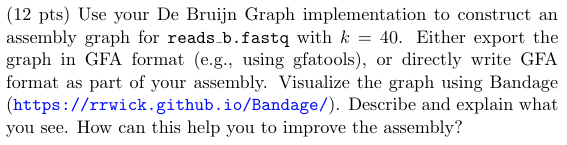

In [9]:
def write_edge_list(graph, output_file):
    with open(output_file, 'w') as f:
        for prefix, suffixes in graph.items():
            for suffix in suffixes:
                f.write(f"{prefix}\t{suffix}\n")

def write_gfa(graph, output_gfa):
    with open(output_gfa, 'w') as f:
        f.write("H\tVN:Z:1.0\n")
        node_ids = {}
        counter = 0
        for prefix, suffixes in graph.items():
            if prefix not in node_ids:
                node_ids[prefix] = f"n{counter}"
                counter += 1
            for suffix in suffixes:
                if suffix not in node_ids:
                    node_ids[suffix] = f"n{counter}"
                    counter += 1
                f.write(f"S\t{node_ids[prefix]}\t{prefix}\n")
                f.write(f"S\t{node_ids[suffix]}\t{suffix}\n")
                f.write(f"L\t{node_ids[prefix]}\t+\t{node_ids[suffix]}\t+\t0M\n")

In [11]:
input_fastq = "synthetic/reads_b.fastq"
kmer_size = 40
output_fasta = "outputs/reads_b_contigs_k40.fasta"
output_gfa = "outputs/reads_b_graph_k40.gfa"

reads = parse_fastq(input_fastq)
kmer_counts = build_kmer_counts(reads, kmer_size)
graph, in_deg, out_deg = build_filtered_dbg(kmer_counts, kmer_size, min_count=2)
contigs = assemble_unitigs(graph, in_deg, out_deg)
write_fasta(contigs, output_fasta)
write_gfa(graph, output_gfa)
print(f"Generated {len(contigs)} contigs.")
print("GFA file saved to:", output_gfa)

Generated 1 contigs.
GFA file saved to: outputs/reads_b_graph_k40.gfa


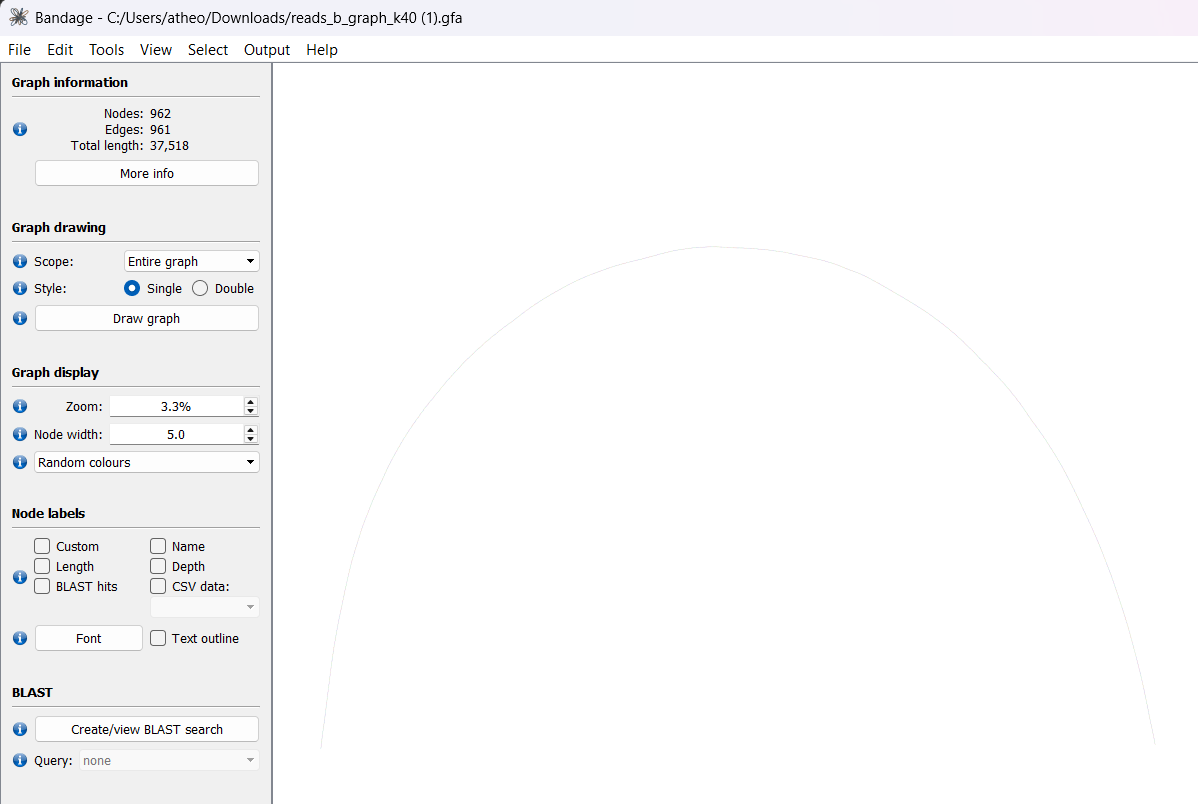

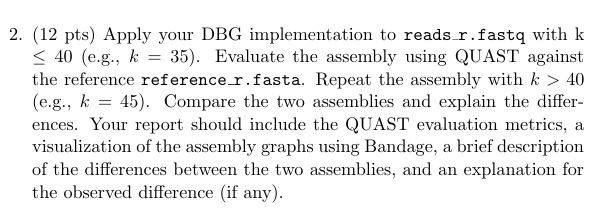

In [18]:
input_fastq = "synthetic/reads_r.fastq"
kmer_size = 35
output_fasta = "outputs/reads_r_contigs_k35.fasta"
output_gfa = "outputs/reads_r_graph_k35.gfa"

reads = parse_fastq(input_fastq)
kmer_counts = build_kmer_counts(reads, kmer_size)
graph, in_deg, out_deg = build_filtered_dbg(kmer_counts, kmer_size, min_count=2)
contigs = assemble_unitigs(graph, in_deg, out_deg)
write_fasta(contigs, output_fasta)
write_gfa(graph, output_gfa)
print(f"Generated {len(contigs)} contigs.")
print("GFA file saved to:", output_gfa)

Generated 4 contigs.
GFA file saved to: outputs/reads_r_graph_k35.gfa


In [19]:
!quast outputs/reads_r_contigs_k35.fasta -r synthetic/reference_r.fasta -o outputs/quast_r_k35 --min-contig 0

/home/saitaa0b/miniconda3/envs/bioasst2/bin/quast outputs/reads_r_contigs_k35.fasta -r synthetic/reference_r.fasta -o outputs/quast_r_k35 --min-contig 0

Version: 5.3.0

System information:
  OS: Linux-5.14.0-427.20.1.el9_4.0.1.x86_64-x86_64-with-glibc2.34 (linux_64)
  Python version: 3.9.19
  CPUs number: 32

Started: 2025-05-09 06:57:27

Logging to /home/saitaa0b/bio/outputs/quast_r_k35/quast.log
NOTICE: Output directory already exists and looks like a QUAST output dir. Existing results can be reused (e.g. previously generated alignments)!
NOTICE: Maximum number of threads is set to 8 (use --threads option to set it manually)

CWD: /home/saitaa0b/bio
Main parameters: 
  MODE: default, threads: 8, min contig length: 0, min alignment length: 65, min alignment IDY: 95.0, \
  ambiguity: one, min local misassembly length: 200, min extensive misassembly length: 1000

Reference:
  /home/saitaa0b/bio/synthetic/reference_r.fasta ==> reference_r

Contigs:
  Pre-processing...
  outputs/reads_r_

In [20]:
report_path = "outputs/quast_r_k35/report.txt"
metrics = parse_quast_report(report_path)

print("Parsed QUAST Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v}")

Parsed QUAST Metrics:
Sequence length: 1136
# contigs (>= 0 bp): 4
# contigs (>= 1000 bp): 0
# contigs (>= 5000 bp): 0
# contigs (>= 10000 bp): 0
# contigs (>= 25000 bp): 0
# contigs (>= 50000 bp): 0
GC content (%): 50.79
Genome fraction (%): 100.000
Duplication ratio: 1.008
Largest contig: 914
N50: 914
N90: 134
L50: 1
Misassemblies: 0
Mismatches per 100 kbp: 0.00
Indels per 100 kbp: 0.00


### QUAST evaluation

| **Metric**                 | **R k=35 (DBG)** |
|----------------------------|------------------|
| Sequence length            |1136                 |
| # contigs (>= 0 bp)        |4                  |
| # contigs (>= 1000 bp) |0                  |           
| # contigs (>= 5000 bp) |0                  |      
| # contigs (>= 10000 bp)|0                  |          
| # contigs (>= 25000 bp)|0                  |             
| # contigs (>= 50000 bp)|0                  |   
| GC content (%)             |50.79                  | 
| Genome fraction (%)        |100.000                 |                
| Duplication ratio          |1.008                  |                  
| Largest contig             |914                  |                  
| N50                        |914                  |                  
| N90                        |134                  |               
| L50                        |1                  |                 
| Misassemblies              |0                  |              
| Mismatches per 100 kbp     |0.00                  |            
| Indels per 100 kbp         |0.00                  |       


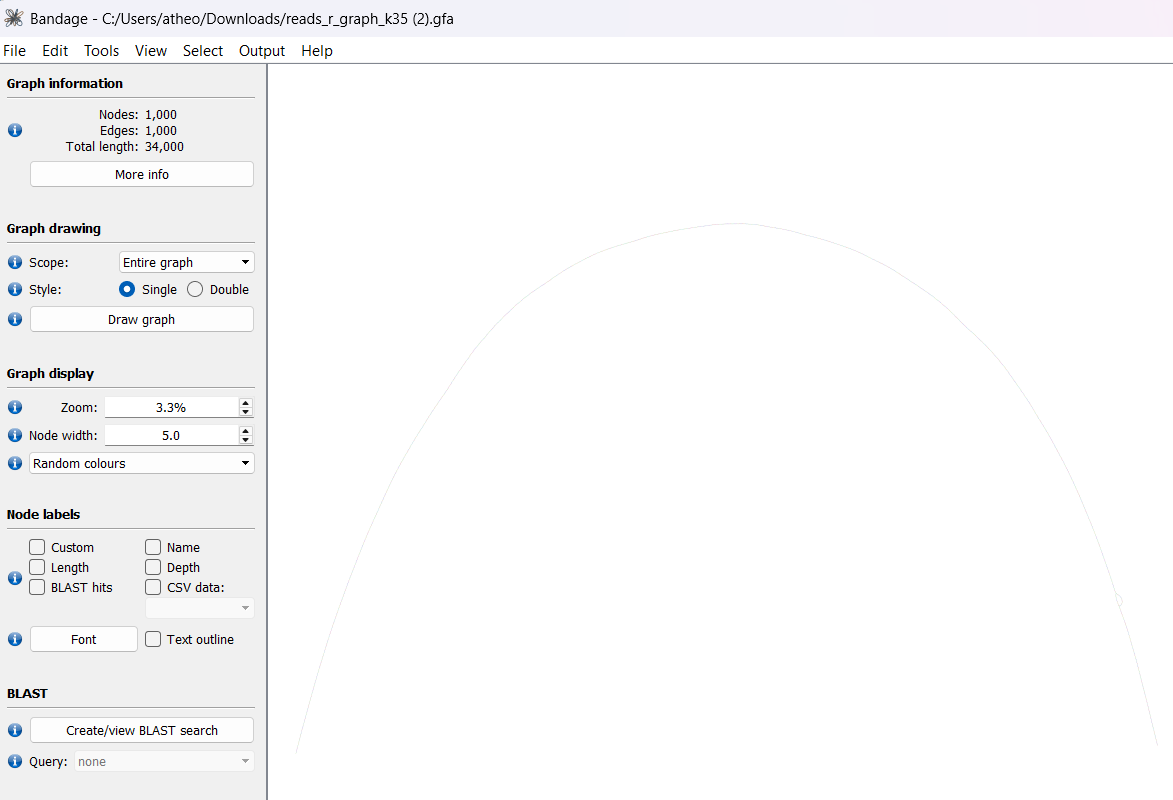

small bubble to the right

In [22]:
input_fastq = "synthetic/reads_r.fastq"
kmer_size = 45
output_fasta = "outputs/reads_r_contigs_k45.fasta"
output_gfa = "outputs/reads_r_graph_k45.gfa"

reads = parse_fastq(input_fastq)
kmer_counts = build_kmer_counts(reads, kmer_size)
graph, in_deg, out_deg = build_filtered_dbg(kmer_counts, kmer_size, min_count=2)
contigs = assemble_unitigs(graph, in_deg, out_deg)
write_fasta(contigs, output_fasta)
write_gfa(graph, output_gfa)
print(f"Generated {len(contigs)} contigs.")
print("GFA file saved to:", output_gfa)

Generated 1 contigs.
GFA file saved to: outputs/reads_r_graph_k45.gfa


In [23]:
!quast outputs/reads_r_contigs_k45.fasta -r synthetic/reference_r.fasta -o outputs/quast_r_k45 --min-contig 0

/home/saitaa0b/miniconda3/envs/bioasst2/bin/quast outputs/reads_r_contigs_k45.fasta -r synthetic/reference_r.fasta -o outputs/quast_r_k45 --min-contig 0

Version: 5.3.0

System information:
  OS: Linux-5.14.0-427.20.1.el9_4.0.1.x86_64-x86_64-with-glibc2.34 (linux_64)
  Python version: 3.9.19
  CPUs number: 32

Started: 2025-05-09 07:03:31

Logging to /home/saitaa0b/bio/outputs/quast_r_k45/quast.log
NOTICE: Output directory already exists and looks like a QUAST output dir. Existing results can be reused (e.g. previously generated alignments)!
NOTICE: Maximum number of threads is set to 8 (use --threads option to set it manually)

CWD: /home/saitaa0b/bio
Main parameters: 
  MODE: default, threads: 8, min contig length: 0, min alignment length: 65, min alignment IDY: 95.0, \
  ambiguity: one, min local misassembly length: 200, min extensive misassembly length: 1000

Reference:
  /home/saitaa0b/bio/synthetic/reference_r.fasta ==> reference_r

Contigs:
  Pre-processing...
  outputs/reads_r_

In [24]:
report_path = "outputs/quast_r_k45/report.txt"
metrics = parse_quast_report(report_path)

print("Parsed QUAST Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v}")

Parsed QUAST Metrics:
Sequence length: 1040
# contigs (>= 0 bp): 1
# contigs (>= 1000 bp): 1
# contigs (>= 5000 bp): 0
# contigs (>= 10000 bp): 0
# contigs (>= 25000 bp): 0
# contigs (>= 50000 bp): 0
GC content (%): 51.25
Genome fraction (%): 100.000
Duplication ratio: 1.000
Largest contig: 1040
N50: 1040
N90: 1040
L50: 1
Misassemblies: 0
Mismatches per 100 kbp: 0.00
Indels per 100 kbp: 0.00


### QUAST evaluation

| **Metric**                 | **R k=45 (DBG)** |
|----------------------------|------------------|
| Sequence length            |1040                  |
| # contigs (>= 0 bp)        |1                  |
| # contigs (>= 1000 bp) |1                  |                 
| # contigs (>= 5000 bp) |0                  |                 
| # contigs (>= 10000 bp)|0                  |                  
| # contigs (>= 25000 bp)|0                  |                   
| # contigs (>= 50000 bp)|0                  |                 
| GC content (%)             |51.25                  | 
| Genome fraction (%)        |100.000                  |                
| Duplication ratio          |1.000                  |                  
| Largest contig             |1040                  |                  
| N50                        |1040                  |                  
| N90                        |1040                  |               
| L50                        |1                  |                 
| Misassemblies              |0                  |              
| Mismatches per 100 kbp     |0.00                  |            
| Indels per 100 kbp         |0.00                  |       


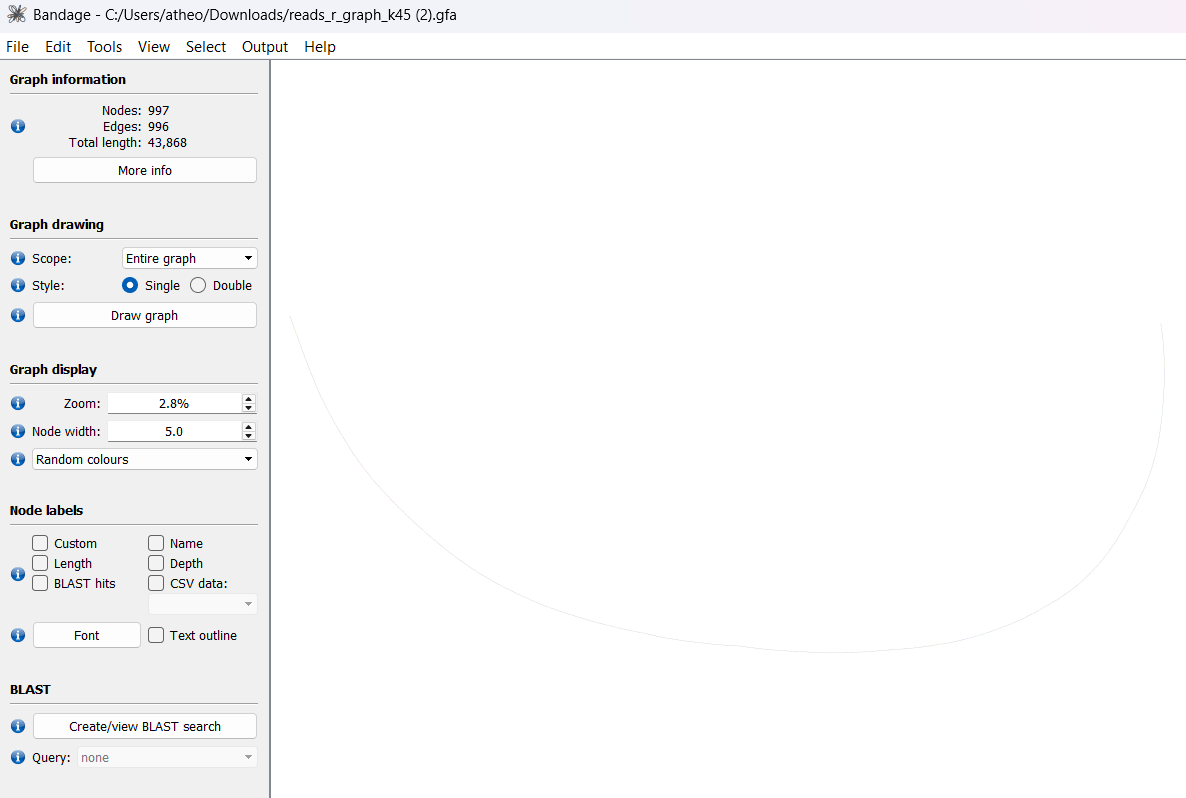

bubble is gone

### QUAST evaluation for both DBG graphs

| **Metric**                 | **R k=35 (DBG)** | **R k=45 (DBG)** |
|----------------------------|------------------|------------------|
| Total length               |1136            |1040                  |                  |                  |
| # contigs (>= 0 bp)        |4               |1                  |                  |                  |
| # contigs (>= 1000 bp) |0                  |1                      |                |                   |
| # contigs (>= 5000 bp) |0                  |0                      |                |                   |
| # contigs (>= 10000 bp)|0                  |0                      |                |                   |
| # contigs (>= 25000 bp)|0                  |0                      |                |                   |
| # contigs (>= 50000 bp)|0                  |0                      |                |                   |
| GC content (%)             |50.79             |51.25                  |                  |                  |
| Genome fraction (%)        |100.000           |100.000                  |                  |                  |
| Duplication ratio          |1.008           |1.000                  |                  |                  |
| Largest contig             |914               |1040                  |                  |                  |
| N50                        |914               |1040                  |                  |                  |
| N90                        |134               |1040                  |                  |                  |
| L50                        |1               |1                  |                  |                  |
| Misassemblies              |0                 |0                  |                  |                  |
| Mismatches per 100 kbp     |0.00              |0.00                  |                  |                  |
| Indels per 100 kbp         |0.00             |0.00                  |                  |                  |


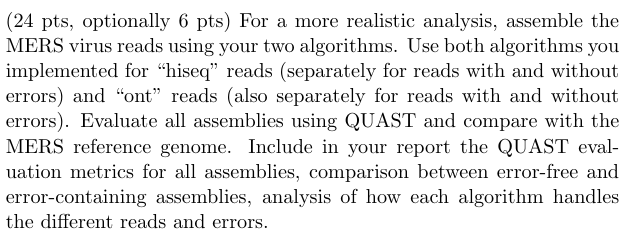

### no_error_reads_hiseq_5k.fastq

In [26]:
input_fastq = "mers/no_error_reads_hiseq_5k.fastq"
kmer_size = 45
output_fasta = "outputs/DBG/no_error_reads_hiseq_5k_contigs_k45.fasta"

reads = parse_fastq(input_fastq)
kmer_counts = build_kmer_counts(reads, kmer_size)
graph, in_deg, out_deg = build_filtered_dbg(kmer_counts, kmer_size, min_count=2)
contigs = assemble_unitigs(graph, in_deg, out_deg)
write_fasta(contigs, output_fasta)
write_gfa(graph, output_gfa)
print(f"Generated {len(contigs)} contigs.")

Generated 11 contigs.


In [27]:
!quast outputs/DBG/no_error_reads_hiseq_5k_contigs_k45.fasta -r mers/mers_reference.fna -o outputs/quast_mers_DBG_k45_no_error_reads_hiseq_5k --min-contig 0

/home/saitaa0b/miniconda3/envs/bioasst2/bin/quast outputs/DBG/no_error_reads_hiseq_5k_contigs_k45.fasta -r mers/mers_reference.fna -o outputs/quast_mers_DBG_k45_no_error_reads_hiseq_5k --min-contig 0

Version: 5.3.0

System information:
  OS: Linux-5.14.0-427.20.1.el9_4.0.1.x86_64-x86_64-with-glibc2.34 (linux_64)
  Python version: 3.9.19
  CPUs number: 32

Started: 2025-05-09 07:15:34

Logging to /home/saitaa0b/bio/outputs/quast_mers_DBG_k45_no_error_reads_hiseq_5k/quast.log
NOTICE: Output directory already exists and looks like a QUAST output dir. Existing results can be reused (e.g. previously generated alignments)!
NOTICE: Maximum number of threads is set to 8 (use --threads option to set it manually)

CWD: /home/saitaa0b/bio
Main parameters: 
  MODE: default, threads: 8, min contig length: 0, min alignment length: 65, min alignment IDY: 95.0, \
  ambiguity: one, min local misassembly length: 200, min extensive misassembly length: 1000

Reference:
  /home/saitaa0b/bio/mers/mers_refe

In [28]:
report_path = "outputs/quast_mers_DBG_k45_no_error_reads_hiseq_5k/report.txt"
metrics = parse_quast_report(report_path)

print("Parsed QUAST Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v}")

Parsed QUAST Metrics:
Sequence length: 29776
# contigs (>= 0 bp): 11
# contigs (>= 1000 bp): 8
# contigs (>= 5000 bp): 1
# contigs (>= 10000 bp): 0
# contigs (>= 25000 bp): 0
# contigs (>= 50000 bp): 0
GC content (%): 41.22
Genome fraction (%): 97.812
Duplication ratio: 1.011
Largest contig: 8525
N50: 4462
N90: 1700
L50: 3
Misassemblies: 0
Mismatches per 100 kbp: 0.00
Indels per 100 kbp: 0.00


In [29]:
input_fastq = "mers/no_error_reads_hiseq_5k.fastq" 
reads = parse_fastq(input_fastq)
reads = reads + [reverse_complement(r) for r in reads]x
reads = remove_contained_reads(reads)
graph, indegree, outdegree = build_overlap_graph(reads, min_length=44)
contigs = layout_reads_consensus(graph, indegree, outdegree, reads, min_contig_len=0)
contigs = polish_contigs_with_reads(contigs, reads)
output_fasta = "outputs/OLC/no_error_reads_hiseq_5k_consensus_min44.fasta"
write_fasta(contigs, output_fasta)
print(f"Generated {len(contigs)} contigs with consensus.")

Generated 44 contigs with consensus.


In [30]:
!quast outputs/OLC/no_error_reads_hiseq_5k_consensus_min44.fasta -r mers/mers_reference.fna -o outputs/quast_mers_OLC_min44_no_error_reads_hiseq_5k --min-contig 0

/home/saitaa0b/miniconda3/envs/bioasst2/bin/quast outputs/OLC/no_error_reads_hiseq_5k_consensus_min44.fasta -r mers/mers_reference.fna -o outputs/quast_mers_OLC_min44_no_error_reads_hiseq_5k --min-contig 0

Version: 5.3.0

System information:
  OS: Linux-5.14.0-427.20.1.el9_4.0.1.x86_64-x86_64-with-glibc2.34 (linux_64)
  Python version: 3.9.19
  CPUs number: 32

Started: 2025-05-09 07:18:34

Logging to /home/saitaa0b/bio/outputs/quast_mers_OLC_min44_no_error_reads_hiseq_5k/quast.log
NOTICE: Output directory already exists and looks like a QUAST output dir. Existing results can be reused (e.g. previously generated alignments)!
NOTICE: Maximum number of threads is set to 8 (use --threads option to set it manually)

CWD: /home/saitaa0b/bio
Main parameters: 
  MODE: default, threads: 8, min contig length: 0, min alignment length: 65, min alignment IDY: 95.0, \
  ambiguity: one, min local misassembly length: 200, min extensive misassembly length: 1000

Reference:
  /home/saitaa0b/bio/mers/m

In [31]:
report_path = "outputs/quast_mers_OLC_min44_no_error_reads_hiseq_5k/report.txt"
metrics = parse_quast_report(report_path)

print("Parsed QUAST Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v}")

Parsed QUAST Metrics:
Sequence length: 63446
# contigs (>= 0 bp): 44
# contigs (>= 1000 bp): 11
# contigs (>= 5000 bp): 4
# contigs (>= 10000 bp): 2
# contigs (>= 25000 bp): 0
# contigs (>= 50000 bp): 0
GC content (%): 41.21
Genome fraction (%): 97.885
Duplication ratio: 2.152
Largest contig: 11813
N50: 5006
N90: 603
L50: 4
Misassemblies: 0
Mismatches per 100 kbp: 9.46
Indels per 100 kbp: 0.00


### reads_hiseq_5k.fastq

In [32]:
input_fastq = "mers/reads_hiseq_5k.fastq"
kmer_size = 45
output_fasta = "outputs/DBG/reads_hiseq_5k_contigs_k45.fasta"

reads = parse_fastq(input_fastq)
kmer_counts = build_kmer_counts(reads, kmer_size)
graph, in_deg, out_deg = build_filtered_dbg(kmer_counts, kmer_size, min_count=2)
contigs = assemble_unitigs(graph, in_deg, out_deg)
write_fasta(contigs, output_fasta)
write_gfa(graph, output_gfa)
print(f"Generated {len(contigs)} contigs.")

Generated 24 contigs.


In [33]:
!quast outputs/DBG/reads_hiseq_5k_contigs_k45.fasta -r mers/mers_reference.fna -o outputs/quast_mers_DBG_k45_reads_hiseq_5k --min-contig 0

/home/saitaa0b/miniconda3/envs/bioasst2/bin/quast outputs/DBG/reads_hiseq_5k_contigs_k45.fasta -r mers/mers_reference.fna -o outputs/quast_mers_DBG_k45_reads_hiseq_5k --min-contig 0

Version: 5.3.0

System information:
  OS: Linux-5.14.0-427.20.1.el9_4.0.1.x86_64-x86_64-with-glibc2.34 (linux_64)
  Python version: 3.9.19
  CPUs number: 32

Started: 2025-05-09 07:19:58

Logging to /home/saitaa0b/bio/outputs/quast_mers_DBG_k45_reads_hiseq_5k/quast.log
NOTICE: Output directory already exists and looks like a QUAST output dir. Existing results can be reused (e.g. previously generated alignments)!
NOTICE: Maximum number of threads is set to 8 (use --threads option to set it manually)

CWD: /home/saitaa0b/bio
Main parameters: 
  MODE: default, threads: 8, min contig length: 0, min alignment length: 65, min alignment IDY: 95.0, \
  ambiguity: one, min local misassembly length: 200, min extensive misassembly length: 1000

Reference:
  /home/saitaa0b/bio/mers/mers_reference.fna ==> mers_referenc

In [34]:
report_path = "outputs/quast_mers_DBG_k45_reads_hiseq_5k/report.txt"
metrics = parse_quast_report(report_path)

print("Parsed QUAST Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v}")

Parsed QUAST Metrics:
Sequence length: 30270
# contigs (>= 0 bp): 24
# contigs (>= 1000 bp): 11
# contigs (>= 5000 bp): 0
# contigs (>= 10000 bp): 0
# contigs (>= 25000 bp): 0
# contigs (>= 50000 bp): 0
GC content (%): 41.27
Genome fraction (%): 97.812
Duplication ratio: 1.018
Largest contig: 4185
N50: 2405
N90: 820
L50: 5
Misassemblies: 0
Mismatches per 100 kbp: 0.00
Indels per 100 kbp: 0.00


In [35]:
input_fastq = "mers/reads_hiseq_5k.fastq"
reads = parse_fastq(input_fastq)
reads = reads + [reverse_complement(r) for r in reads]
reads = remove_contained_reads(reads)
graph, indegree, outdegree = build_overlap_graph(reads, min_length=44)
contigs = layout_reads_consensus(graph, indegree, outdegree, reads, min_contig_len=0)
contigs = polish_contigs_with_reads(contigs, reads)
output_fasta = "outputs/OLC/reads_hiseq_5k_consensus_min44.fasta"
write_fasta(contigs, output_fasta)
print(f"Generated {len(contigs)} contigs with consensus.")

Generated 880 contigs with consensus.


In [36]:
!quast outputs/OLC/reads_hiseq_5k_consensus_min44.fasta -r mers/mers_reference.fna -o outputs/quast_mers_OLC_min44_reads_hiseq_5k --min-contig 0

/home/saitaa0b/miniconda3/envs/bioasst2/bin/quast outputs/OLC/reads_hiseq_5k_consensus_min44.fasta -r mers/mers_reference.fna -o outputs/quast_mers_OLC_min44_reads_hiseq_5k --min-contig 0

Version: 5.3.0

System information:
  OS: Linux-5.14.0-427.20.1.el9_4.0.1.x86_64-x86_64-with-glibc2.34 (linux_64)
  Python version: 3.9.19
  CPUs number: 32

Started: 2025-05-09 07:21:40

Logging to /home/saitaa0b/bio/outputs/quast_mers_OLC_min44_reads_hiseq_5k/quast.log
NOTICE: Output directory already exists and looks like a QUAST output dir. Existing results can be reused (e.g. previously generated alignments)!
NOTICE: Maximum number of threads is set to 8 (use --threads option to set it manually)

CWD: /home/saitaa0b/bio
Main parameters: 
  MODE: default, threads: 8, min contig length: 0, min alignment length: 65, min alignment IDY: 95.0, \
  ambiguity: one, min local misassembly length: 200, min extensive misassembly length: 1000

Reference:
  /home/saitaa0b/bio/mers/mers_reference.fna ==> mers_

In [37]:
report_path = "outputs/quast_mers_OLC_min44_reads_hiseq_5k/report.txt"
metrics = parse_quast_report(report_path)

print("Parsed QUAST Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v}")

Parsed QUAST Metrics:
Sequence length: 163956
# contigs (>= 0 bp): 880
# contigs (>= 1000 bp): 4
# contigs (>= 5000 bp): 0
# contigs (>= 10000 bp): 0
# contigs (>= 25000 bp): 0
# contigs (>= 50000 bp): 0
GC content (%): 41.09
Genome fraction (%): 97.885
Duplication ratio: 5.518
Largest contig: 1798
N50: 166
N90: 126
L50: 246
Misassemblies: 0
Mismatches per 100 kbp: 302.45
Indels per 100 kbp: 0.00


### no_error_ont_hq_50x

In [38]:
input_fastq = "mers/no_error_ont_hq_50x.fastq"
kmer_size = 45
output_fasta = "outputs/DBG/no_error_ont_hq_50x_k45.fasta"

reads = parse_fastq(input_fastq)
kmer_counts = build_kmer_counts(reads, kmer_size)
graph, in_deg, out_deg = build_filtered_dbg(kmer_counts, kmer_size, min_count=2)
contigs = assemble_unitigs(graph, in_deg, out_deg)
write_fasta(contigs, output_fasta)
write_gfa(graph, output_gfa)
print(f"Generated {len(contigs)} contigs.")

Generated 1 contigs.


In [39]:
!quast outputs/DBG/no_error_ont_hq_50x_k45.fasta -r mers/mers_reference.fna -o outputs/quast_mers_DBG_k45_no_error_ont_hq_50x --min-contig 0

/home/saitaa0b/miniconda3/envs/bioasst2/bin/quast outputs/DBG/no_error_ont_hq_50x_k45.fasta -r mers/mers_reference.fna -o outputs/quast_mers_DBG_k45_no_error_ont_hq_50x --min-contig 0

Version: 5.3.0

System information:
  OS: Linux-5.14.0-427.20.1.el9_4.0.1.x86_64-x86_64-with-glibc2.34 (linux_64)
  Python version: 3.9.19
  CPUs number: 32

Started: 2025-05-09 07:21:45

Logging to /home/saitaa0b/bio/outputs/quast_mers_DBG_k45_no_error_ont_hq_50x/quast.log
NOTICE: Output directory already exists and looks like a QUAST output dir. Existing results can be reused (e.g. previously generated alignments)!
NOTICE: Maximum number of threads is set to 8 (use --threads option to set it manually)

CWD: /home/saitaa0b/bio
Main parameters: 
  MODE: default, threads: 8, min contig length: 0, min alignment length: 65, min alignment IDY: 95.0, \
  ambiguity: one, min local misassembly length: 200, min extensive misassembly length: 1000

Reference:
  /home/saitaa0b/bio/mers/mers_reference.fna ==> mers_r

In [40]:
report_path = "outputs/quast_mers_DBG_k45_no_error_ont_hq_50x/report.txt"
metrics = parse_quast_report(report_path)

print("Parsed QUAST Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v}")

Parsed QUAST Metrics:
Sequence length: 29400
# contigs (>= 0 bp): 1
# contigs (>= 1000 bp): 1
# contigs (>= 5000 bp): 1
# contigs (>= 10000 bp): 1
# contigs (>= 25000 bp): 1
# contigs (>= 50000 bp): 0
GC content (%): 41.16
Genome fraction (%): 97.613
Duplication ratio: 1.000
Largest contig: 29400
N50: 29400
N90: 29400
L50: 1
Misassemblies: 0
Mismatches per 100 kbp: 0.00
Indels per 100 kbp: 0.00


In [41]:
input_fastq = "mers/no_error_ont_hq_50x.fastq"
reads = parse_fastq(input_fastq)
reads = reads + [reverse_complement(r) for r in reads]
reads = remove_contained_reads(reads)
graph, indegree, outdegree = build_overlap_graph(reads, min_length=44)
contigs = layout_reads_consensus(graph, indegree, outdegree, reads, min_contig_len=0)
contigs = polish_contigs_with_reads(contigs, reads)
output_fasta = "outputs/OLC/no_error_ont_hq_50x_consensus_min44.fasta"
write_fasta(contigs, output_fasta)
print(f"Generated {len(contigs)} contigs with consensus.")

Generated 10 contigs with consensus.


In [42]:
!quast outputs/OLC/no_error_ont_hq_50x_consensus_min44.fasta -r mers/mers_reference.fna -o outputs/quast_mers_OLC_min44_no_error_ont_hq_50x --min-contig 0

/home/saitaa0b/miniconda3/envs/bioasst2/bin/quast outputs/OLC/no_error_ont_hq_50x_consensus_min44.fasta -r mers/mers_reference.fna -o outputs/quast_mers_OLC_min44_no_error_ont_hq_50x --min-contig 0

Version: 5.3.0

System information:
  OS: Linux-5.14.0-427.20.1.el9_4.0.1.x86_64-x86_64-with-glibc2.34 (linux_64)
  Python version: 3.9.19
  CPUs number: 32

Started: 2025-05-09 07:22:46

Logging to /home/saitaa0b/bio/outputs/quast_mers_OLC_min44_no_error_ont_hq_50x/quast.log
NOTICE: Output directory already exists and looks like a QUAST output dir. Existing results can be reused (e.g. previously generated alignments)!
NOTICE: Maximum number of threads is set to 8 (use --threads option to set it manually)

CWD: /home/saitaa0b/bio
Main parameters: 
  MODE: default, threads: 8, min contig length: 0, min alignment length: 65, min alignment IDY: 95.0, \
  ambiguity: one, min local misassembly length: 200, min extensive misassembly length: 1000

Reference:
  /home/saitaa0b/bio/mers/mers_referenc

In [43]:
report_path = "outputs/quast_mers_OLC_min44_no_error_ont_hq_50x/report.txt"
metrics = parse_quast_report(report_path)

print("Parsed QUAST Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v}")

Parsed QUAST Metrics:
Sequence length: 136453
# contigs (>= 0 bp): 10
# contigs (>= 1000 bp): 10
# contigs (>= 5000 bp): 10
# contigs (>= 10000 bp): 8
# contigs (>= 25000 bp): 1
# contigs (>= 50000 bp): 0
GC content (%): 41.06
Genome fraction (%): 98.768
Duplication ratio: 4.587
Largest contig: 28146
N50: 12949
N90: 9472
L50: 4
Misassemblies: 0
Mismatches per 100 kbp: 0.00
Indels per 100 kbp: 0.00


### ont_hq_50x

In [44]:
input_fastq = "mers/ont_hq_50x.fastq"
kmer_size = 45
output_fasta = "outputs/DBG/ont_hq_50x_ontigs_k45.fasta"

reads = parse_fastq(input_fastq)
kmer_counts = build_kmer_counts(reads, kmer_size)
graph, in_deg, out_deg = build_filtered_dbg(kmer_counts, kmer_size, min_count=2)
contigs = assemble_unitigs(graph, in_deg, out_deg)
write_fasta(contigs, output_fasta)
write_gfa(graph, output_gfa)
print(f"Generated {len(contigs)} contigs.")

Generated 1177 contigs.


In [45]:
!quast outputs/DBG/ont_hq_50x_ontigs_k45.fasta -r mers/mers_reference.fna -o outputs/quast_mers_DBG_k45_ont_hq_50x --min-contig 0

/home/saitaa0b/miniconda3/envs/bioasst2/bin/quast outputs/DBG/ont_hq_50x_ontigs_k45.fasta -r mers/mers_reference.fna -o outputs/quast_mers_DBG_k45_ont_hq_50x --min-contig 0

Version: 5.3.0

System information:
  OS: Linux-5.14.0-427.20.1.el9_4.0.1.x86_64-x86_64-with-glibc2.34 (linux_64)
  Python version: 3.9.19
  CPUs number: 32

Started: 2025-05-09 07:23:33

Logging to /home/saitaa0b/bio/outputs/quast_mers_DBG_k45_ont_hq_50x/quast.log
NOTICE: Output directory already exists and looks like a QUAST output dir. Existing results can be reused (e.g. previously generated alignments)!
NOTICE: Maximum number of threads is set to 8 (use --threads option to set it manually)

CWD: /home/saitaa0b/bio
Main parameters: 
  MODE: default, threads: 8, min contig length: 0, min alignment length: 65, min alignment IDY: 95.0, \
  ambiguity: one, min local misassembly length: 200, min extensive misassembly length: 1000

Reference:
  /home/saitaa0b/bio/mers/mers_reference.fna ==> mers_reference

Contigs:
 

In [46]:
report_path = "outputs/quast_mers_DBG_k45_ont_hq_50x/report.txt"
metrics = parse_quast_report(report_path)

print("Parsed QUAST Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v}")

Parsed QUAST Metrics:
Sequence length: 111841
# contigs (>= 0 bp): 1177
# contigs (>= 1000 bp): 4
# contigs (>= 5000 bp): 0
# contigs (>= 10000 bp): 0
# contigs (>= 25000 bp): 0
# contigs (>= 50000 bp): 0
GC content (%): 40.68
Genome fraction (%): 96.105
Duplication ratio: 2.651
Largest contig: 3237
N50: 112
N90: 46
L50: 235
Misassemblies: 0
Mismatches per 100 kbp: 0.00
Indels per 100 kbp: 44.31


In [47]:
input_fastq = "mers/ont_hq_50x.fastq"
reads = parse_fastq(input_fastq)
reads = reads + [reverse_complement(r) for r in reads]
reads = remove_contained_reads(reads)
graph, indegree, outdegree = build_overlap_graph(reads, min_length=44)
contigs = layout_reads_consensus(graph, indegree, outdegree, reads, min_contig_len=0)
contigs = polish_contigs_with_reads(contigs, reads)
output_fasta = "outputs/OLC/ont_hq_50x_consensus_min44.fasta"
write_fasta(contigs, output_fasta)
print(f"Generated {len(contigs)} contigs with consensus.")

Generated 8 contigs with consensus.


In [48]:
!quast outputs/OLC/ont_hq_50x_consensus_min44.fasta -r mers/mers_reference.fna -o outputs/quast_mers_OLC_min44_ont_hq_50x --min-contig 0

/home/saitaa0b/miniconda3/envs/bioasst2/bin/quast outputs/OLC/ont_hq_50x_consensus_min44.fasta -r mers/mers_reference.fna -o outputs/quast_mers_OLC_min44_ont_hq_50x --min-contig 0

Version: 5.3.0

System information:
  OS: Linux-5.14.0-427.20.1.el9_4.0.1.x86_64-x86_64-with-glibc2.34 (linux_64)
  Python version: 3.9.19
  CPUs number: 32

Started: 2025-05-09 07:24:41

Logging to /home/saitaa0b/bio/outputs/quast_mers_OLC_min44_ont_hq_50x/quast.log
NOTICE: Output directory already exists and looks like a QUAST output dir. Existing results can be reused (e.g. previously generated alignments)!
NOTICE: Maximum number of threads is set to 8 (use --threads option to set it manually)

CWD: /home/saitaa0b/bio
Main parameters: 
  MODE: default, threads: 8, min contig length: 0, min alignment length: 65, min alignment IDY: 95.0, \
  ambiguity: one, min local misassembly length: 200, min extensive misassembly length: 1000

Reference:
  /home/saitaa0b/bio/mers/mers_reference.fna ==> mers_reference

C

In [49]:
report_path = "outputs/quast_mers_OLC_min44_ont_hq_50x/report.txt"
metrics = parse_quast_report(report_path)

print("Parsed QUAST Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v}")

Parsed QUAST Metrics:
Sequence length: 148008
# contigs (>= 0 bp): 8
# contigs (>= 1000 bp): 8
# contigs (>= 5000 bp): 8
# contigs (>= 10000 bp): 8
# contigs (>= 25000 bp): 0
# contigs (>= 50000 bp): 0
GC content (%): 26.91
Genome fraction (%): 9.227
Duplication ratio: 1.144
Largest contig: 20510
N50: 20439
N90: 16201
L50: 4
Misassemblies: 0
Mismatches per 100 kbp: 314.56
Indels per 100 kbp: 471.85


### DBG assemblies

| **Metric**             | **HiSeq (no err)** | **HiSeq (err)** | **ONT (no err)** | **ONT (err)** |
|------------------------|--------------------|------------------|------------------|----------------|
| Sequence length        | 29776              | 30270            | 29400            | 111841         |
| # contigs (>= 0 bp)    | 11                 | 24               | 1                | 1177           |
| # contigs (>= 1000 bp) | 8                  | 11               | 1                | 4              |
| # contigs (>= 5000 bp) | 1                  | 0                | 1                | 0              |
| # contigs (>= 10000 bp)| 0                  | 0                | 1                | 0              |
| # contigs (>= 25000 bp)| 0                  | 0                | 1                | 0              |
| # contigs (>= 50000 bp)| 0                  | 0                | 0                | 0              |
| GC content (%)         | 41.22              | 41.27            | 41.16            | 40.68          |
| Genome fraction (%)    | 97.812             | 97.812           | 97.613           | 96.105         |
| Duplication ratio      | 1.011              | 1.018            | 1.000            | 2.651          |
| Largest contig         | 8525               | 4185             | 29400            | 3237           |
| N50                    | 4462               | 2405             | 29400            | 112            |
| N90                    | 1700               | 820              | 29400            | 46             |
| L50                    | 3                  | 5                | 1                | 235            |
| Misassemblies          | 0                  | 0                | 0                | 0              |
| Mismatches per 100kbp  | 0.00               | 0.00             | 0.00             | 0.00           |
| Indels per 100kbp      | 0.00               | 0.00             | 0.00             | 44.31          |


### OLC assemblies

| **Metric**             | **HiSeq (no err)** | **HiSeq (err)** | **ONT (no err)** | **ONT (err)** |
|------------------------|--------------------|------------------|------------------|----------------|
| Sequence length        | 63446              | 163956           | 136453           | 148008         |
| # contigs (>= 0 bp)    | 44                 | 880              | 10               | 8              |
| # contigs (>= 1000 bp) | 11                 | 4                | 10               | 8              |
| # contigs (>= 5000 bp) | 4                  | 0                | 10               | 8              |
| # contigs (>= 10000 bp)| 2                  | 0                | 8                | 8              |
| # contigs (>= 25000 bp)| 0                  | 0                | 1                | 0              |
| # contigs (>= 50000 bp)| 0                  | 0                | 0                | 0              |
| GC content (%)         | 41.21              | 41.09            | 41.06            | 26.91          |
| Genome fraction (%)    | 97.885             | 97.885           | 98.768           | 9.227          |
| Duplication ratio      | 2.152              | 5.518            | 4.587            | 1.144          |
| Largest contig         | 11813              | 1798             | 28146            | 20510          |
| N50                    | 5006               | 166              | 12949            | 20439          |
| N90                    | 603                | 126              | 9472             | 16201          |
| L50                    | 4                  | 246              | 4                | 4              |
| Misassemblies          | 0                  | 0                | 0                | 0              |
| Mismatches per 100kbp  | 9.46               | 302.45           | 0.00             | 314.56         |
| Indels per 100kbp      | 0.00               | 0.00             | 0.00             | 471.85         |


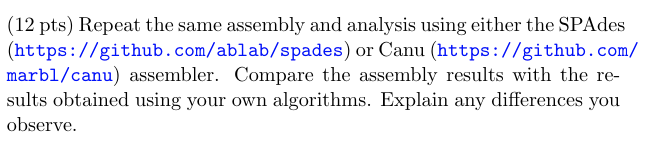

# SPAdes

Ran in terminal

`!mamba install -c bioconda -c conda-forge spades canu`

`spades.py -s mers/no_error_reads_hiseq_5k.fastq -o outputs/spades_output_no_error --phred-offset 33`

In [15]:
!quast outputs/spades_output_no_error/contigs.fasta -r mers/mers_reference.fna -o outputs/quast_spades_no_error --min-contig 0

/home/saitaa0b/miniconda3/envs/bioasst2/bin/quast outputs/spades_output_no_error/contigs.fasta -r mers/mers_reference.fna -o outputs/quast_spades_no_error --min-contig 0

Version: 5.3.0

System information:
  OS: Linux-5.14.0-427.20.1.el9_4.0.1.x86_64-x86_64-with-glibc2.34 (linux_64)
  Python version: 3.9.19
  CPUs number: 48

Started: 2025-05-05 07:27:35

Logging to /home/saitaa0b/bio/outputs/quast_spades_no_error/quast.log
NOTICE: Output directory already exists and looks like a QUAST output dir. Existing results can be reused (e.g. previously generated alignments)!
NOTICE: Maximum number of threads is set to 12 (use --threads option to set it manually)

CWD: /home/saitaa0b/bio
Main parameters: 
  MODE: default, threads: 12, min contig length: 0, min alignment length: 65, min alignment IDY: 95.0, \
  ambiguity: one, min local misassembly length: 200, min extensive misassembly length: 1000

Reference:
  /home/saitaa0b/bio/mers/mers_reference.fna ==> mers_reference

Contigs:
  Pre-proc

In [16]:
report_path = "outputs/quast_spades_no_error/report.txt"
metrics = parse_quast_report(report_path)

print("Parsed QUAST Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v}")

Parsed QUAST Metrics:
Sequence length: 29482
# contigs (>= 0 bp): 1
# contigs (>= 1000 bp): 1
# contigs (>= 5000 bp): 1
# contigs (>= 10000 bp): 1
# contigs (>= 25000 bp): 1
# contigs (>= 50000 bp): 0
GC content (%): 41.26
Genome fraction (%): 97.885
Duplication ratio: 1.000
Largest contig: 29482
N50: 29482
N90: 29482
L50: 1
Misassemblies: 0
Mismatches per 100 kbp: 0.00
Indels per 100 kbp: 0.00


Ran in terminal

`spades.py -s mers/reads_hiseq_5k.fastq -o outputs/spades_output_error --phred-offset 33`

In [17]:
!quast outputs/spades_output_error/contigs.fasta -r mers/mers_reference.fna -o outputs/quast_spades_error --min-contig 0

/home/saitaa0b/miniconda3/envs/bioasst2/bin/quast outputs/spades_output_error/contigs.fasta -r mers/mers_reference.fna -o outputs/quast_spades_error --min-contig 0

Version: 5.3.0

System information:
  OS: Linux-5.14.0-427.20.1.el9_4.0.1.x86_64-x86_64-with-glibc2.34 (linux_64)
  Python version: 3.9.19
  CPUs number: 48

Started: 2025-05-05 07:27:47

Logging to /home/saitaa0b/bio/outputs/quast_spades_error/quast.log
NOTICE: Output directory already exists and looks like a QUAST output dir. Existing results can be reused (e.g. previously generated alignments)!
NOTICE: Maximum number of threads is set to 12 (use --threads option to set it manually)

CWD: /home/saitaa0b/bio
Main parameters: 
  MODE: default, threads: 12, min contig length: 0, min alignment length: 65, min alignment IDY: 95.0, \
  ambiguity: one, min local misassembly length: 200, min extensive misassembly length: 1000

Reference:
  /home/saitaa0b/bio/mers/mers_reference.fna ==> mers_reference

Contigs:
  Pre-processing...

In [18]:
report_path = "outputs/quast_spades_error/report.txt"
metrics = parse_quast_report(report_path)

print("Parsed QUAST Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v}")

Parsed QUAST Metrics:
Sequence length: 29482
# contigs (>= 0 bp): 1
# contigs (>= 1000 bp): 1
# contigs (>= 5000 bp): 1
# contigs (>= 10000 bp): 1
# contigs (>= 25000 bp): 1
# contigs (>= 50000 bp): 0
GC content (%): 41.26
Genome fraction (%): 97.885
Duplication ratio: 1.000
Largest contig: 29482
N50: 29482
N90: 29482
L50: 1
Misassemblies: 0
Mismatches per 100 kbp: 0.00
Indels per 100 kbp: 0.00


### DBG assemblies

| **Metric**             |**DBG (hiseq no err)**| **DBG (hiseq err)**      |**SPAdes (hiseq no err)**| **SPAdes (hiseq err)**     |
|------------------------|------------------|----------------------|----------------|-------------------|
| Sequence length        |29776            |30270                |29482         |29482            |
| # contigs (>= 0 bp)    |11              |24                  |1             |1                |
| # contigs (>= 1000 bp) |8                |11                    |1             |1                |
| # contigs (>= 5000 bp) |1                 |0                     |1              |1                |
| # contigs (>= 10000 bp)|0                 |0                     |1              |1                 |
| # contigs (>= 25000 bp)|0                 |0                     |1               |1                  |
| # contigs (>= 50000 bp)|0                 |0                     |0               |0                  |
| GC content (%)         |41.22             |41.27                 |41.26           |41.26              |
| Genome fraction (%)    |97.812            |97.812                |97.885          |97.885             |
| Duplication ratio      |1.011             |1.018                 |1.000           |1.000              |
| Largest contig         |8525             |4185                  |29482           |29482              |
| N50                    |4462               |2405                   |29482           |29482              |
| N90                    |1700                |820                    |29482           |29482               |
| L50                    |3               |5                   |1               |1                  |
| Misassemblies          |0                 |0                     |0               |0                  |
| Mismatches per 100kbp  |0.00              |0.00                |0.00            |0.00               |
| Indels per 100kbp      |0.00              |0.00                  |0.00            |0.00               |


Ran in terminal

`canu -p mers -d canu_output genomeSize=30k -nanopore-raw mers/ont_hq_50x.fastq useGrid=false maxThreads=16 maxMemory=100`

`quast canu_output/mers.contigs.fasta -r mers/mers_reference.fna -o quast_canu_output_mers`

`canu -p mers_no_error -d canu_output_no_error genomeSize=30k -nanopore-raw mers/no_error_ont_hq_50x.fastq useGrid=false maxThreads=16 maxMemory=100`

`quast canu_output_no_error/mers_no_error.contigs.fasta -r mers/mers_reference.fna -o quast_canu_output_noerror_mers`

In [4]:
report_path = "quast_canu_output_noerror_mers/report.txt"
metrics = parse_quast_report(report_path)

print("Parsed QUAST Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v}")

Parsed QUAST Metrics:
Sequence length: 28655
# contigs (>= 0 bp): 1
# contigs (>= 1000 bp): 1
# contigs (>= 5000 bp): 1
# contigs (>= 10000 bp): 1
# contigs (>= 25000 bp): 1
# contigs (>= 50000 bp): 0
GC content (%): 41.05
Genome fraction (%): 95.139
Duplication ratio: 1.000
Largest contig: 28655
N50: 28655
N90: 28655
L50: 1
Misassemblies: 0
Mismatches per 100 kbp: 0.00
Indels per 100 kbp: 0.00


In [3]:
report_path = "quast_canu_output_mers/report.txt"
metrics = parse_quast_report(report_path)

print("Parsed QUAST Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v}")

Parsed QUAST Metrics:
Sequence length: 28564
# contigs (>= 0 bp): 1
# contigs (>= 1000 bp): 1
# contigs (>= 5000 bp): 1
# contigs (>= 10000 bp): 1
# contigs (>= 25000 bp): 1
# contigs (>= 50000 bp): 0
GC content (%): 41.06
Genome fraction (%): 94.837
Duplication ratio: 1.000
Largest contig: 28564
N50: 28564
N90: 28564
L50: 1
Misassemblies: 0
Mismatches per 100 kbp: 0.00
Indels per 100 kbp: 0.00


### OLC assemblies

| **Metric**             | **OLC (ont no err)** | **OLC (ont err)** | **canu (ont no err)** | **canu (ont err)** |
|------------------------|------------------|---------------|------------------------|---------------------|
| Sequence length        | 136453           | 148008         | 28655                  | 28564               |
| # contigs (>= 0 bp)    | 10              | 8             | 1                      | 1                   |
| # contigs (>= 1000 bp) | 10              | 8             | 1                      | 1                   |
| # contigs (>= 5000 bp) | 10              | 8             | 1                      | 1                   |
| # contigs (>= 10000 bp)| 8               | 8             | 1                      | 1                   |
| # contigs (>= 25000 bp)| 1                | 0             | 1                      | 1                   |
| # contigs (>= 50000 bp)| 0                | 0             | 0                      | 0                   |
| GC content (%)         | 41.06            | 26.91         | 41.05                  | 41.06               |
| Genome fraction (%)    | 98.768           | 9.227        | 95.139                 | 94.837              |
| Duplication ratio      | 4.587           | 1.144         | 1.000                  | 1.000               |
| Largest contig         | 28146            | 20510         | 28655                  | 28564               |
| N50                    | 12949             | 20439         | 28655                  | 28564               |
| N90                    | 9472             | 16201         | 28655                  | 28564               |
| L50                    | 4               | 4             | 1                      | 1                   |
| Misassemblies          | 0                | 0             | 0                      | 0                   |
| Mismatches per 100kbp  | 0.00             | 314.56        | 0.00                   | 0.00                |
| Indels per 100kbp      | 0.00             | 471.85       | 0.00                   | 0.00                |


# Genome Assembly

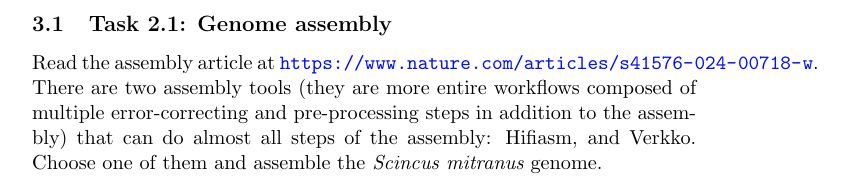

I used Verkko to assemble the lizard genome. These are the installations needed:

- conda install verkko

- conda install cmake

- conda install -c bioconda samtools=1.15 ncurses=6.3

- conda install -c conda-forge -c bioconda mashmap blis

- conda install -c bioconda quast

- conda install -c conda-forge -c bioconda busco

- conda install -c bioconda augustus

- conda install -c conda-forge boost=1.85

- conda install -c bioconda meryl

- conda install -c bioconda inspector

Then ran this slurm script with sbatch:


In [ ]:
#!/bin/bash
#SBATCH --job-name=lizard_verkko
#SBATCH --output=lizard_verkko_%j.out
#SBATCH --error=lizard_verkko_%j.err
#SBATCH --cpus-per-task=32
#SBATCH --mem=1000G
#SBATCH --time=72:00:00
#SBATCH --partition=batch
#SBATCH --mail-type=BEGIN
#SBATCH --mail-user=ahmed.sait@kaust.edu.sa
#SBATCH --account=cs249

# Load Verkko module if available, or activate your environment
source /home/saitaa0b/miniconda3/etc/profile.d/conda.sh
conda activate bioasst2

# Run Verkko
verkko \
  -d /ibex/ai/home/saitaa0b/bio/lizard_verkko_output \
  --hifi /ibex/reference/course/cs249/lizard/input/pacbio/lizard_liver_seq.fastq.gz \
  --nano /ibex/reference/course/cs249/lizard/input/ont/lizard_ont.fastq.gz \
  --hic1 /ibex/reference/course/cs249/lizard/input/hic/lizard_hic_R1.fastq.gz \
  --hic2 /ibex/reference/course/cs249/lizard/input/hic/lizard_hic_R2.fastq.gz \
  --threads 32

After approximately 25 hours, an `assembly.fasta` file was outputted. It can be accessed here: `/ibex/scratch/saitaa0b/bio/lizard_verkko_output/assembly.fasta`

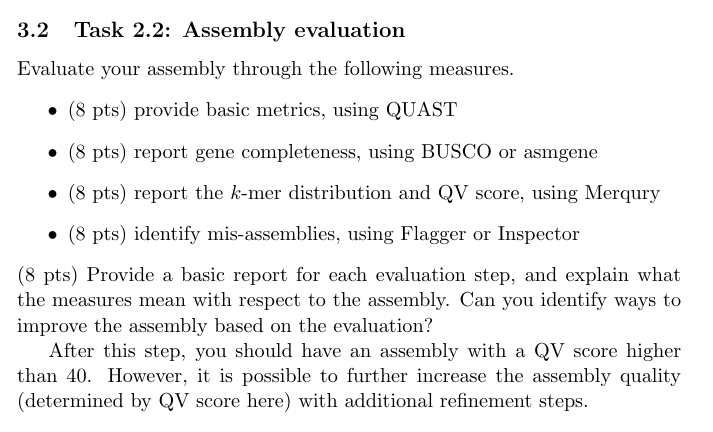

Ran in terminal

`quast lizard_verkko_output/assembly.fasta -o quast_output`

### QUAST evaluation

| **Metric**                 | **Lizard** |
|----------------------------|------------------|
| Sequence length            |3579074559                  |
| # contigs (>= 0 bp)        |3389                  |
| # contigs (>= 1000 bp)     |3389                  |                 
| # contigs (>= 5000 bp)     |3388                  |                 
| # contigs (>= 10000 bp)    |3382                  |                  
| # contigs (>= 25000 bp)    |3212                  |                   
| # contigs (>= 50000 bp)    |2991                  |                 
| GC content (%)             |45.45                  |                   
| Largest contig             |13096494                  |                  
| N50                        |2285482                  |                  
| N90                        |540142                  |               
| L50                        |449                  |                 
| N's per 100kbp             |0.00                  |              
      


# Busco

Ran in the terminal

`export AUGUSTUS_CONFIG_PATH=/home/saitaa0b/miniconda3/envs/bioasst2/config`

`busco -i lizard_verkko_output/assembly.fasta -o busco_output -m genome -l squamata_odb12 -f --augustus`

### BUSCO evaluation

| Category                                   | Count  | Percent     |
|--------------------------------------------|--------|-------------|
| Total BUSCO groups searched                | 11,294 | 100.0%      |
| Complete BUSCOs                       | 10,994 | 97.3%       |
| -- Single-copy                       |   767  | 6.8%        |
| -- Duplicated                          | 10,227 | 90.6%       |
| Fragmented BUSCOs                      |   153  | 1.4%        |
| Missing BUSCOs                         |   147  | 1.3%        |
| BUSCOs with internal stop codons |   475  | 4.3% of Complete BUSCOs   |


# Merqury

Ran in terminal

`conda activate inspector_env`

`conda install -c bioconda meryl`

`conda install -c bioconda merqury`

`
meryl count k=21 output illumina.meryl \
  /ibex/reference/course/cs249/lizard/input/hic/lizard_hic_R1.fastq.gz \
  /ibex/reference/course/cs249/lizard/input/hic/lizard_hic_R2.fastq.gz
`

`merqury.sh illumina.meryl lizard_verkko_output/assembly.fasta merqury_output`

`cat merqury_output.qv`

### Merqury evaluation

| Assembly   | Erroneous k-mers | Total k-mers   | QV Score | Error Rate    |
|------------|------------------|----------------|----------|---------------|
| assembly   | 4,926,417        | 3,579,006,779  | 41.8317  | 6.55895e-05   |


Ran in terminal

`
meryl count k=21 output hifi.meryl \
/ibex/reference/course/cs249/lizard/input/pacbio/lizard_liver.fastq.gz
`

`merqury.sh hifi.meryl lizard_verkko_output/assembly.fasta merqury_output`

`cat merqury_output.qv`

| Assembly   | Erroneous k-mers | Total k-mers   | QV Score | Error Rate    |
|------------|------------------|----------------|----------|---------------|
| assembly   | 1,572,364        | 3,579,006,779  | 46.7934  | 2.09248e-05   |

### k-mer distribution
scp saitaa0b@login.ibex.kaust.edu.sa:/home/saitaa0b/bio/merqury_output.assembly.spectra-cn.fl.png /c/Users/atheo
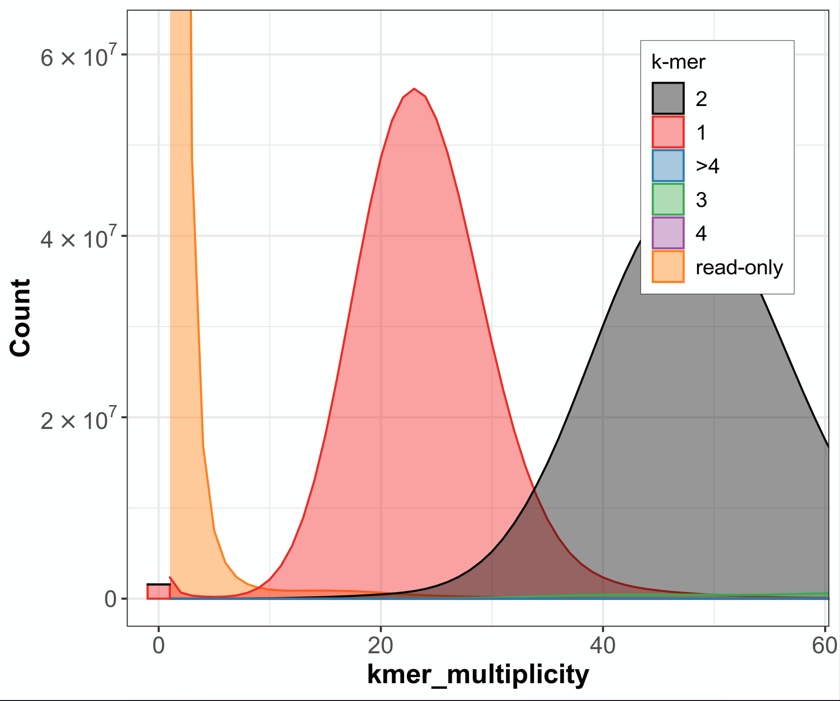

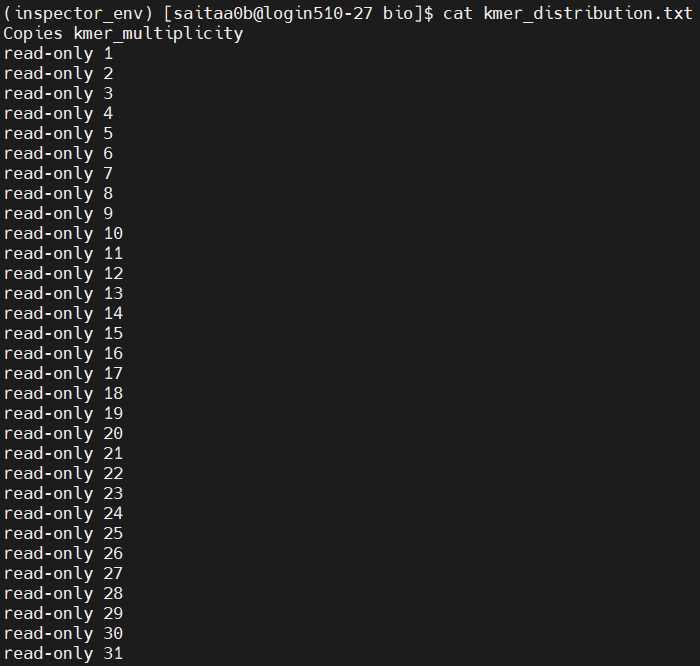

# Inspector

In [ ]:
# Ran in terminal

conda create -n inspector_env -c bioconda -c conda-forge inspector -y

conda activate inspector

minimap2 -t 32 -ax map-hifi \
  lizard_verkko_output/assembly.fasta \
  /ibex/reference/course/cs249/lizard/input/pacbio/lizard_liver_seq.fastq.gz > hifi_align.sam
samtools sort -@ 16 -o hifi_align.bam hifi_align.sam
samtools index hifi_align.bam

mkdir -p inspector_output
DO THESE AFTER lizard_minimap.slurm IS FINISHED
cp hifi_align.bam inspector_output/read_to_contig.bam
cp hifi_align.bam.bai inspector_output/read_to_contig.bam.bai

python /ibex/ai/home/saitaa0b/bio/Inspector/inspector.py \
  --contig lizard_verkko_output/assembly.fasta \
  --read inspector_output/read_to_contig.bam \
  --outpath inspector_output \
  --thread 16 \
  --datatype hifi \
  --skip_read_mapping

### INSPECTOR Results
`cat inspector_output/summary_statistics`

| **Category**                | **Metric**                             | **Value**              |
|----------------------------|----------------------------------------|------------------------|
| **Contig Statistics**      | Number of contigs                      | 3,389                  |
|                            | Contigs > 10,000 bp                    | 3,382                  |
|                            | Contigs > 1,000,000 bp                 | 1,122                  |
|                            | Total length                           | 3,579,074,559 bp       |
|                            | Total length > 10,000 bp               | 3,579,021,697 bp       |
|                            | Total length > 1,000,000 bp            | 2,823,226,069 bp       |
|                            | Longest contig                         | 13,096,494 bp          |
|                            | N50                                     | 2,285,482 bp           |
| **Read Mapping**           | Mapping rate                           | 99.99%                 |
|                            | Split-read rate                        | 0.31%                  |
|                            | Depth                                   | 8.40×                  |
|                            | Mapping rate (large contigs)          | 80.23%                 |
|                            | Split-read rate (large contigs)       | 0.24%                  |
|                            | Depth (large contigs)                 | 8.56×                  |
| **Structural Errors**      | Total structural errors                | 3                      |
|                            | Expansions                             | 1                      |
|                            | Collapses                              | 2                      |
|                            | Haplotype switches                     | 0                      |
|                            | Inversions                             | 0                      |
| **Small-Scale Errors**     | Total                                   | 16,477                 |
|                            | Per Megabase                           | 4.60                   |
|                            | Base substitutions                     | 11,112                 |
|                            | Small expansions                       | 2,342                  |
|                            | Small collapses                        | 3,023                  |
| **Consensus Accuracy**     | QV (Quality Value)                     | 52.95                  |
|                            | Estimated error rate                   | ~1 in 196,000 bases    |
